In [1]:
import os, sys
from copy import deepcopy
sys.path.append("../../")
from utility import utils as uu
sys.path.append("../FTE/")
import pkgs.FTE.finetuning_tasks as ftasks
import numpy as np, random, PIL
import torch, torchvision.transforms.functional as ttf
from tqdm.auto import tqdm
import json
from collections import OrderedDict
from collections import Counter
import math

random.seed(69)
device = "cuda:0"

In [2]:
def get_model_paths(cfg_name):

    with open(cfg_name, "r") as o:
        lines = o.readlines()
    for line in lines:
        if line[0:10] == "model_path":
            pt_model_path = line.split(": ")[-1].split("\"")[1]
        if line[0:4] == "name":
            ft_model_path = "../../logs_and_checkpoints/finetuning/"+line.split(": ")[-1].split("\"")[1]+"/finetuned_model.tar"

    return pt_model_path, ft_model_path

def get_pt_model(cfg_name):

    class Arg:
        pass

    # Argument parsing like in finetune.py
    config = uu.yaml_config_hook(cfg_name)
    args = Arg()
    for k, v in config.items():
        setattr(args, k, v)

    # Defaults like in finetune.py
    args.save_path = os.path.join("../../logs_and_checkpoints/finetuning/", args.name)
    if not "debug" in vars(args):
        args.debug = False
    if not "test_nan_inf" in vars(args):
        args.test_nan_inf = True
    if not os.path.exists(args.save_path):
        os.makedirs(args.save_path)

    if isinstance(vars(args).get("w_l", None), list):
        args.w_l = torch.Tensor(args.w_l)
    else:
        args.w_l = None
    if isinstance(vars(args).get("w_m", None), list):
        args.w_m = torch.Tensor(args.w_m)
    else:
        args.w_m = None

    # Seeding like in finetune.py
    torch.manual_seed(args.seed)
    np.random.seed(args.seed)
    random.seed(args.seed)
    
    # dont need multiple GPUs for this, trick ftasks into not using DataParallel
    args.device = None

    # get PT model
    #print(args.task)
    pt_model = ftasks.model_from_task(args, tf = None)
    
    return pt_model

def get_ft_model(cfg_name, pt_model):

    _, ft_model_path = get_model_paths(cfg_name)
    ft_model = deepcopy(pt_model)
    sd = torch.load(ft_model_path, map_location = torch.device("cpu"))
    dk = []
    for key in sd:
        if any([x in key for x in ["head", "loss", "PLACEHOLDER"]]):
            dk.append(key)
    for key in dk:
        del sd[key]
    ft_model.load_state_dict(sd, strict = False)
    
    return ft_model

def get_ref_batch():

    def load_any(file):
        if file.endswith(".npy"):
            array = np.load(file)
            tensor = torch.tensor(array, dtype = torch.float32)
            tensor = torch.stack([tensor]*3, dim = 0)
            tensor = ttf.resize(tensor, [256, 256])
        elif file.endswith(".JPEG"):
            with PIL.Image.open(file) as f:
                array = np.array(f)
            tensor = torch.tensor(array, dtype = torch.float32)
            tensor = tensor.moveaxis(-1, 0)
            tensor = ttf.resize(tensor, [256, 256])
        else:
            NotImplementedError

        return tensor

    # ref image lists
    f = 0
    i1k_images = uu.getFileList("../../datasets/imagenet-1k/ILSVRC/Data/CLS-LOC/val", ".jpeg")
    rad_images = uu.getFileList("../../datasets/medical_2D/test_wo6", ".npy")

    # randomly choose from each list
    ref_images = []
    random.shuffle(i1k_images)
    random.shuffle(rad_images)
    # cant use too many images - constrained by memory (for small GPUs) and also size of matrix (cub)
    ref_images.extend(i1k_images[0:2])
    #ref_images.extend(rad_images[0:2])

    # load and stack
    ref_images = torch.stack([load_any(image) for image in tqdm(ref_images)], dim = 0)
    
    return ref_images

# Forward hook for activations
activations = {}
layer_weights = {}

def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook


In [3]:
# ref batch
ref_batch = get_ref_batch()
print(ref_batch.size())
ref_batch = ref_batch.to(device)

# dummy targets
dummy_targets = torch.tensor([0])
dummy_targets = dummy_targets.to(device)

# dummy loss criterion
class DummyLossC(torch.nn.Module):

    def __init__(self):
        super(DummyLossC, self).__init__()

    def forward(self, *args):
        return torch.tensor([0], device = device)
DummyLoss = DummyLossC()

100%|██████████| 25000/25000 [00:00<00:00, 224088.70it/s]


  0%|          | 0/2 [00:00<?, ?it/s]

/home/freddy/miniconda3/envs/TLADB/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


torch.Size([2, 3, 256, 256])


In [4]:
def collect_activations_from_model(model, name):

    with torch.no_grad():
        if "LiTS" in name or "BraTS" in name:
            model.unet.backbone.conv1.register_forward_hook(get_activation(name+"_L1"))
            model.unet.backbone.layer1[0].conv1.register_forward_hook(get_activation(name+"_L2"))
            model.unet.backbone.layer1[0].conv2.register_forward_hook(get_activation(name+"_L3"))
        else:
            model.encoder.conv1.register_forward_hook(get_activation(name+"_L1"))
            model.encoder.layer1[0].conv1.register_forward_hook(get_activation(name+"_L2"))
            model.encoder.layer1[0].conv2.register_forward_hook(get_activation(name+"_L3"))
        model.loss_criterion = DummyLoss
        _ = model(ref_batch, dummy_targets)
        for L in ["_L1", "_L2", "_L3"]:
            activations[name+L] = activations[name+L].moveaxis(1, -1).flatten(end_dim = -2)#.to(dtype = torch.float16)#.cpu().numpy()

In [5]:
def collect_layer_weights_from_model(model, name):

    # Get weights
    if "LiTS" in name or "BraTS" in name:
        lw1 = model.unet.backbone.conv1.weight
        lw2 = model.unet.backbone.layer1[0].conv1.weight
        lw3 = model.unet.backbone.layer1[0].conv2.weight
    else:
        lw1 = model.encoder.conv1.weight
        lw2 = model.encoder.layer1[0].conv1.weight
        lw3 = model.encoder.layer1[0].conv2.weight

    # Flatten all except channel dimension
    layer_weights[name+"_L1"] = lw1.moveaxis(1, -1).flatten(end_dim = -2)
    layer_weights[name+"_L2"] = lw2.moveaxis(1, -1).flatten(end_dim = -2)
    layer_weights[name+"_L3"] = lw3.moveaxis(1, -1).flatten(end_dim = -2)

In [20]:
base_path = "../../pkgs/FTE/config/"

es = ["E1", "E6"] #, "E2", "E3", "E4", "E8"] <- We could do this all experiments, but the comparison does not make much sense for E4/E8, and E2/E3 are not that accurate to begin with, plus E3 has no uncertainty estimation runs

pt_extract = {
    "PT_Scratch": "../../pkgs/FTE/config/E1/PT_Scratch_FT_R.yaml",
    "PT_SimCLR_I1k": "../../pkgs/FTE/config/E1/PT_SimCLR_I1k_FT_R.yaml",
    "PT_SimCLR_RF": "../../pkgs/FTE/config/E1/PT_SimCLR_RF_FT_R.yaml",
    "PT_SimCLR_R": "../../pkgs/FTE/config/E1/PT_SimCLR_R_FT_R.yaml",
    "PT_SimCLR_IxRS": "../../pkgs/FTE/config/E6/PT_SimCLR_IxRS_FT_R.yaml",
    "PT_SimCLR_IxRM": "../../pkgs/FTE/config/E6/PT_SimCLR_IxRM_FT_R.yaml",
}
runs = {e: [f 
            for f in uu.getFileList(base_path+e, ".yaml") 
            if not any([x in f for x in ["_tr.yaml", "_testing.yaml", "_PVOC"]])] # ignore any logs of stuff outside the paper
            for e in es}

def ft_cfg_names_to_name(cfg_name):
    split = cfg_name.split("/")
    filename = split[-2]+"/"+split[-1][:-5]
    return filename


100%|██████████| 16/16 [00:00<00:00, 68829.60it/s]


In [21]:
# model states after pretraining
for name, run_cfg in tqdm(pt_extract.items()):
    pt_model_path, _ = get_model_paths(run_cfg)
    pt_model = get_pt_model(run_cfg)
    pt_model = pt_model.to(device)
    pt_model.eval()
    collect_activations_from_model(pt_model, name) # Not actually used
    collect_layer_weights_from_model(pt_model, name)

# model states after finetuning
for e in es:
    for run_cfg in tqdm(runs[e]):
        name = ft_cfg_names_to_name(run_cfg)
        #print(name)
        _, ft_model_path = get_model_paths(run_cfg)
        pt_model = get_pt_model(run_cfg)
        ft_model = get_ft_model(run_cfg, pt_model)
        ft_model = ft_model.to(device)
        ft_model.eval()
        collect_activations_from_model(ft_model, name) # Not actually used
        collect_layer_weights_from_model(ft_model, name)

  0%|          | 0/6 [00:00<?, ?it/s]

/home/freddy/miniconda3/envs/TLADB/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/freddy/miniconda3/envs/TLADB/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

In [22]:
from gpuCKA import CudaCKA
CCKA_inst = CudaCKA(device)
import matplotlib, matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [31]:
screen_names = {
    "PT_Scratch": "No pretraining ('Scratch')",
    "PT_SimCLR_I1k": "Pretrained on ImageNet-1k",
    "PT_SimCLR_R": "Pretrained on RadNet-1.28M",
    "PT_SimCLR_RF": "Pretrained on RadNet-12M",
    "PT_SimCLR_IxRS": "P.o. I-1k + R-1.28M, Seq.",
    "PT_SimCLR_IxRM": "P.o. I-1k + R-1.28M, Mix.",
    "E1/PT_Scratch_FT_BraTS": "PT Scratch, FT BraTS",
    "E1/PT_Scratch_FT_CX8": "PT Scratch, FT ChestX-ray8",
    "E1/PT_Scratch_FT_I1k": "PT Scratch, FT ImageNet-1k",
    "E1/PT_Scratch_FT_LiTS": "PT Scratch, FT LiTS",
    "E1/PT_Scratch_FT_R": "PT Scratch, FT RadNet-1.28M",
    "E1/PT_SimCLR_I1k_FT_BraTS": "PT ImageNet-1k, FT BraTS",
    "E1/PT_SimCLR_I1k_FT_CX8": "PT ImageNet-1k, FT ChestX-ray8",
    "E1/PT_SimCLR_I1k_FT_I1k": "PT ImageNet-1k, FT ImageNet-1k",
    "E1/PT_SimCLR_I1k_FT_LiTS": "PT ImageNet-1k, FT LiTS",
    "E1/PT_SimCLR_I1k_FT_R": "PT ImageNet-1k, FT RadNet-1.28M",
    "E1/PT_SimCLR_R_FT_BraTS": "PT RadNet-1.28M, FT BraTS",
    "E1/PT_SimCLR_R_FT_CX8": "PT RadNet-1.28M, FT ChestX-ray8",
    "E1/PT_SimCLR_R_FT_I1k": "PT RadNet-1.28M, FT ImageNet-1k",
    "E1/PT_SimCLR_R_FT_LiTS": "PT RadNet-1.28M, FT LiTS",
    "E1/PT_SimCLR_R_FT_R": "PT RadNet-1.28M, FT RadNet-1.28M",
    "E1/PT_SimCLR_RF_FT_BraTS": "PT RadNet-12M, FT BraTS",
    "E1/PT_SimCLR_RF_FT_CX8": "PT RadNet-12M, FT ChestX-ray8",
    "E1/PT_SimCLR_RF_FT_I1k": "PT RadNet-12M, FT ImageNet-1k",
    "E1/PT_SimCLR_RF_FT_LiTS": "PT RadNet-12M, FT LiTS",
    "E1/PT_SimCLR_RF_FT_R": "PT RadNet-12M, FT RadNet-1.28M",
    "E6/PT_SimCLR_IxRS_FT_R": "PT both (seq.), FT RadNet-1.28M",
    "E6/PT_SimCLR_IxRS_FT_I1k": "PT both (seq.), FT ImageNet-1k",
    "E6/PT_SimCLR_IxRM_FT_R": "PT both (mix.), FT RadNet-1.28M",
    "E6/PT_SimCLR_IxRM_FT_I1k": "PT both (mix.), FT ImageNet-1k",
    "FT_BraTS": "Finetuned on BraTS", 
    "FT_CX8": "Finetuned on ChestX-ray8", 
    "FT_I1k": "Finetuned on ImageNet-1k", 
    "FT_LiTS": "Finetuned on LiTS", 
    "FT_R": "Finetuned on RadNet-1.28M",
}

In [26]:
def get_variations(name):
    if any([name.endswith(x) for x in ["_L1", "_L2", "_L3"]]):
        l = name[-3:]
        n = name[:-3]
    else:
        l = ""
        n = name
    variations = [n+l]
    variations.extend([n+x+l for x in ["_f1", "_f2", "_f3"]])
    return variations

In [27]:
# Feature Reuse E1
pt_acts = {name: act for name, act in layer_weights.items() if not "_FT_" in name and not "E6" in name}
pt_names = ["PT_Scratch", "PT_SimCLR_I1k", "PT_SimCLR_R", "PT_SimCLR_RF"]
ft_names = ["FT_BraTS", "FT_CX8", "FT_I1k", "FT_LiTS", "FT_R"]

results_means = {}
results_stds = {}
for pn in tqdm(pt_names):
    for L in ["_L1", "_L2", "_L3"]:
        for fn in tqdm(ft_names):
            n1 = pn+L
            n2 = get_variations("E1/"+pn+"_"+fn+L)
            sim = np.array([
                CCKA_inst.kernel_CKA(pt_acts[n1], layer_weights[n2v]).detach().cpu().numpy()
                for n2v in n2
                ])
            mean = np.mean(sim)
            std = np.std(sim)
            results_means[(pn, fn, L)] = mean
            results_stds[(pn, fn, L)] = std

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

In [28]:
# Feature Reuse E6
E6_pt_acts = {name: act for name, act in layer_weights.items() if not "_FT_" in name}
E6_pt_names = ["PT_SimCLR_I1k", "PT_SimCLR_IxRS", "PT_SimCLR_IxRM", "PT_SimCLR_R"]
E6_ft_names = ["FT_I1k", "FT_R"]

E6_results_means = {}
E6_results_stds = {}
for pn in tqdm(E6_pt_names):
    for L in ["_L1", "_L2", "_L3"]:
        for fn in tqdm(E6_ft_names):
            n1 = pn+L
            n2 = get_variations(f"E{'6' if 'x' in pn else '1'}/"+pn+"_"+fn+L)
            sim = np.array([
                CCKA_inst.kernel_CKA(pt_acts[n1], layer_weights[n2v]).detach().cpu().numpy()
                for n2v in n2
                ])
            mean = np.mean(sim)
            std = np.std(sim)
            E6_results_means[(pn, fn, L)] = mean
            E6_results_stds[(pn, fn, L)] = std

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

In [30]:
for k, v in results_means.items():
    print(f"E1 - {k}: {v}")
for k, v in E6_results_means.items():
    print(f"E6 - {k}: {v}")

E1 - ('PT_Scratch', 'FT_BraTS', '_L1'): 0.44502225518226624
E1 - ('PT_Scratch', 'FT_CX8', '_L1'): 0.27675750851631165
E1 - ('PT_Scratch', 'FT_I1k', '_L1'): 0.044806670397520065
E1 - ('PT_Scratch', 'FT_LiTS', '_L1'): 0.7730423212051392
E1 - ('PT_Scratch', 'FT_R', '_L1'): 0.9998249411582947
E1 - ('PT_Scratch', 'FT_BraTS', '_L2'): 0.9854676723480225
E1 - ('PT_Scratch', 'FT_CX8', '_L2'): 0.9698197841644287
E1 - ('PT_Scratch', 'FT_I1k', '_L2'): 0.5758568048477173
E1 - ('PT_Scratch', 'FT_LiTS', '_L2'): 0.9979493618011475
E1 - ('PT_Scratch', 'FT_R', '_L2'): 0.9999592304229736
E1 - ('PT_Scratch', 'FT_BraTS', '_L3'): 0.7435611486434937
E1 - ('PT_Scratch', 'FT_CX8', '_L3'): 0.6012405157089233
E1 - ('PT_Scratch', 'FT_I1k', '_L3'): 0.11850263923406601
E1 - ('PT_Scratch', 'FT_LiTS', '_L3'): 0.9639506936073303
E1 - ('PT_Scratch', 'FT_R', '_L3'): 0.9998735785484314
E1 - ('PT_SimCLR_I1k', 'FT_BraTS', '_L1'): 0.9936293363571167
E1 - ('PT_SimCLR_I1k', 'FT_CX8', '_L1'): 0.991347074508667
E1 - ('PT_SimCLR

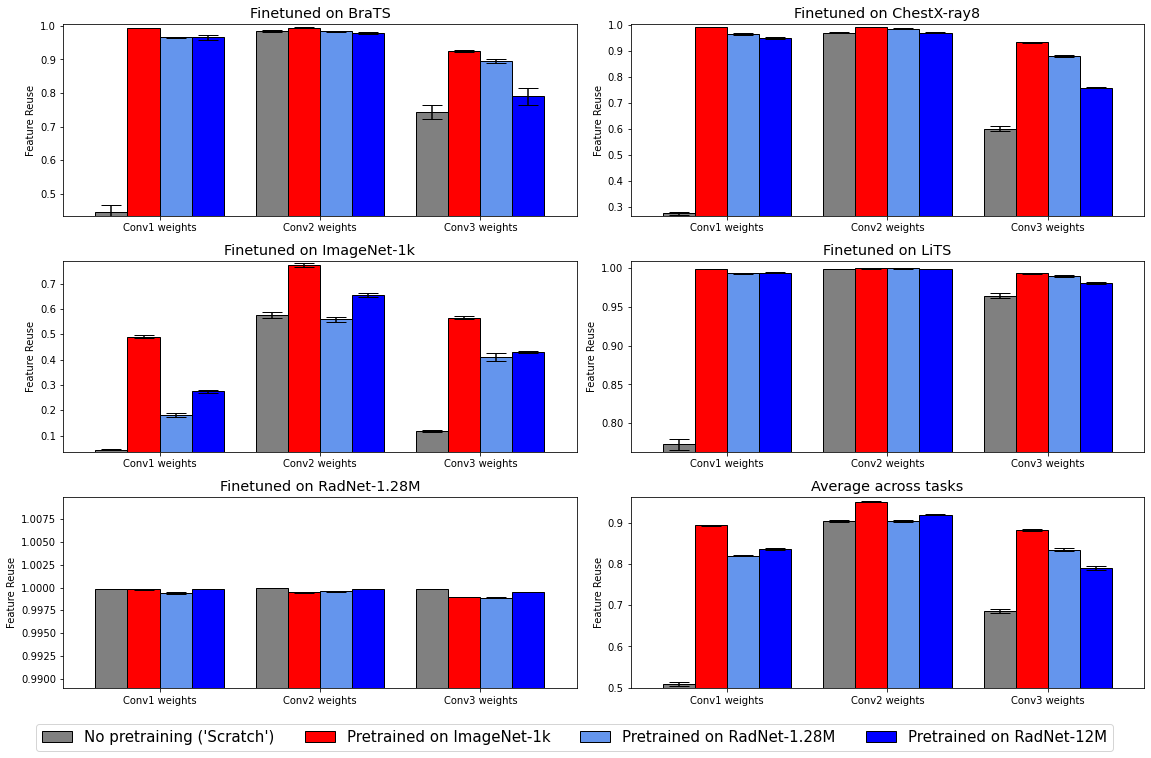

In [14]:
# Feature Reuse plots
ttc_palette = {
    "PT_Scratch": "gray",
    "PT_SimCLR_I1k": "red",
    "PT_SimCLR_R": "cornflowerblue",
    "PT_SimCLR_RF": "blue"
}

fig, axes = plt.subplots(nrows = 3, ncols = 2, figsize = (16, 10))
for k, task in enumerate(["FT_BraTS", "FT_CX8", "FT_I1k", "FT_LiTS", "FT_R"]):
    ax = axes[k // 2, k % 2]
    plt.rcParams.update({'axes.titlesize': 'x-large'})
    plt.rcParams.update({'axes.labelsize': 'large'})
    ax.set_title(f"{screen_names[task]}")
    ax.set_xticks([1.5, 4, 6.5])
    ax.set_xticklabels(["Conv1 weights", "Conv2 weights", "Conv3 weights"])
    ax.set_ylabel("Feature Reuse")
    ax.set_xlim(0, 8)
    ax.set_ylim(
        min([results_means[(pn, task, L)] - 0.01 for pn in pt_names for L in ["_L1", "_L2", "_L3"]]),
        max([results_means[(pn, task, L)] + results_stds[(pn, task, L)] + 0.01 for pn in pt_names for L in ["_L1", "_L2", "_L3"]]))
    for j, L in enumerate(["_L1", "_L2", "_L3"]):
        bars = [results_means[(pn, task, L)] for pn in pt_names]
        errs = [results_stds[(pn, task, L)] for pn in pt_names]
        if j == 2:
            labels = [screen_names[pn] for pn in pt_names]
        else:
            labels = ["", "", "", ""]
        colors = [ttc_palette[pn] for pn in pt_names]
        pos = [0.5*i + 2.5*j + 0.5 for i in range(len(pt_names))]
        for l in range(len(pos)):
            ax.bar(
                x = pos[l],
                height = bars[l],
                width = 0.5,
                yerr = errs[l],
                capsize = 10,
                label = labels[l],
                color = colors[l],
                align = "edge",
                edgecolor = "k",
                linewidth = 1
            )
ax = axes[2, 1]
task = "Average across tasks"
plt.rcParams.update({'axes.titlesize': 'x-large'})
plt.rcParams.update({'axes.labelsize': 'large'})
ax.set_title(task)
ax.set_xticks([1.5, 4, 6.5])
ax.set_xticklabels(["Conv1 weights", "Conv2 weights", "Conv3 weights"])
ax.set_ylabel("Feature Reuse")
ax.set_xlim(0, 8)
for pn in pt_names:
    for L in ["_L1", "_L2", "_L3"]:
        results_means[(pn, "avg", L)] = np.mean([results_means[(pn, task, L)] for task in ["FT_BraTS", "FT_CX8", "FT_I1k", "FT_LiTS", "FT_R"]])
        results_stds[(pn, "avg", L)] = 1/5 * np.sqrt(sum([results_stds[(pn, task, L)]**2 for task in ["FT_BraTS", "FT_CX8", "FT_I1k", "FT_LiTS", "FT_R"]]))
ax.set_ylim(
    min([results_means[(pn, "avg", L)] - 0.01 for pn in pt_names for L in ["_L1", "_L2", "_L3"]]),
    max([results_means[(pn, "avg", L)] + results_stds[(pn, "avg", L)] + 0.01 for pn in pt_names for L in ["_L1", "_L2", "_L3"]]))
for j, L in enumerate(["_L1", "_L2", "_L3"]):
    bars = [results_means[(pn, "avg", L)] for pn in pt_names]
    errs = [results_stds[(pn, "avg", L)] for pn in pt_names]
    if j == 2:
        labels = [screen_names[pn] for pn in pt_names]
    else:
        labels = ["", "", "", ""]
    colors = [ttc_palette[pn] for pn in pt_names]
    pos = [0.5*i + 2.5*j + 0.5 for i in range(len(pt_names))]
    for l in range(len(pos)):
        ax.bar(
            x = pos[l],
            height = bars[l],
            width = 0.5,
            yerr = errs[l],
            capsize = 10,
            label = labels[l],
            color = colors[l],
            align = "edge",
            edgecolor = "k",
            linewidth = 1
        )
#for task, ax in zip(
#    ["Finetuned on BraTS",
#     "Finetuned on ChestX-Ray8",
#     "Finetuned on ImageNet-1k",
#     "Finetuned on LiTS",
#     "Finetuned on BraTS",
#     "Average across tasks"],
#    axes.flatten()):
#    extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
#    fig.savefig(f"./figures/Feature_Reuse_Task_{task}.svg", format = "svg", bbox_inches = extent)
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor = [0.97, 0.0], prop = {'size': 15}, ncol = 4)
fig.subplots_adjust(hspace = 1.0, wspace = 1.0)
fig.tight_layout()
#axes[2, 1].set_visible(False)

plt.savefig(f"./figures/Feature_Reuse_E1.svg", format = "svg", bbox_inches = "tight")

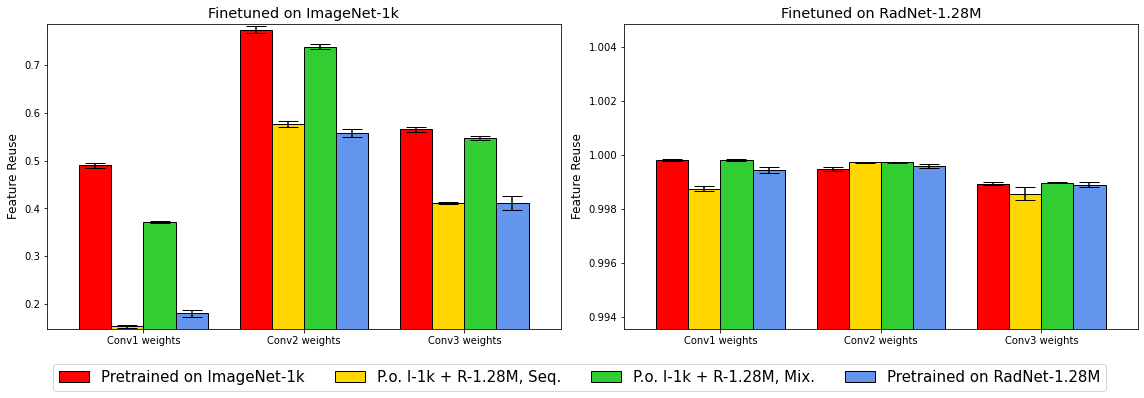

In [39]:
# E6 Feature Reuse plots
ttc_palette = {
    "PT_SimCLR_I1k": "red",
    "PT_SimCLR_IxRS": "gold",
    "PT_SimCLR_IxRM": "limegreen",
    "PT_SimCLR_R": "cornflowerblue",
}

fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (16, 5))
for k, task in enumerate(["FT_I1k", "FT_R"]):
    ax = axes[k]
    plt.rcParams.update({'axes.titlesize': 'x-large'})
    plt.rcParams.update({'axes.labelsize': 'large'})
    ax.set_title(f"{screen_names[task]}")
    ax.set_xticks([1.5, 4, 6.5])
    ax.set_xticklabels(["Conv1 weights", "Conv2 weights", "Conv3 weights"])
    ax.set_ylabel("Feature Reuse")
    ax.set_xlim(0, 8)
    ax.set_ylim(
        min([E6_results_means[(pn, task, L)] - 0.005 for pn in E6_pt_names for L in ["_L1", "_L2", "_L3"]]),
        max([E6_results_means[(pn, task, L)] + E6_results_stds[(pn, task, L)] + 0.005 for pn in E6_pt_names for L in ["_L1", "_L2", "_L3"]]))
    for j, L in enumerate(["_L1", "_L2", "_L3"]):
        bars = [E6_results_means[(pn, task, L)] for pn in E6_pt_names]
        errs = [E6_results_stds[(pn, task, L)] for pn in E6_pt_names]
        if j == 2:
            labels = [screen_names[pn] for pn in E6_pt_names]
        else:
            labels = ["", "", "", ""]
        colors = [ttc_palette[pn] for pn in E6_pt_names]
        pos = [0.5*i + 2.5*j + 0.5 for i in range(len(E6_pt_names))]
        for l in range(len(pos)):
            ax.bar(
                x = pos[l],
                height = bars[l],
                width = 0.5,
                yerr = errs[l],
                capsize = 10,
                label = labels[l],
                color = colors[l],
                align = "edge",
                edgecolor = "k",
                linewidth = 1
            )
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor = [0.97, 0.0], prop = {'size': 15}, ncol = 4)
fig.subplots_adjust(hspace = 1.0, wspace = 1.0)
fig.tight_layout()

plt.savefig(f"./figures/Feature_Reuse_E6.svg", format = "svg", bbox_inches = "tight")

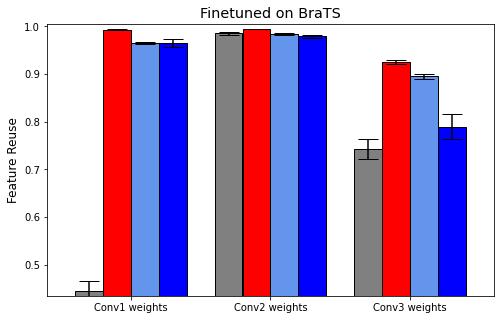

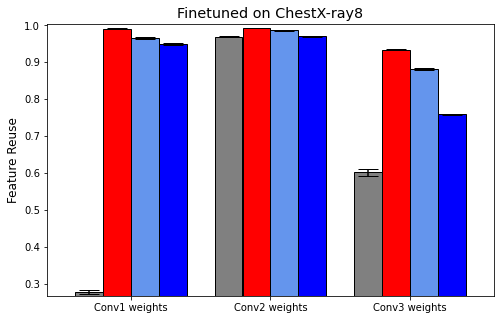

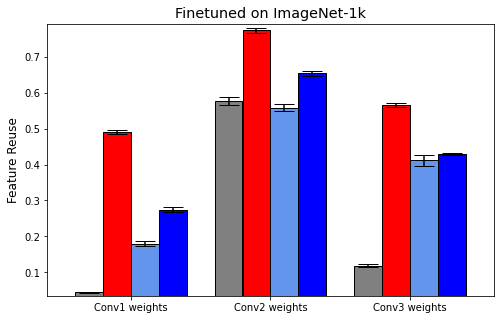

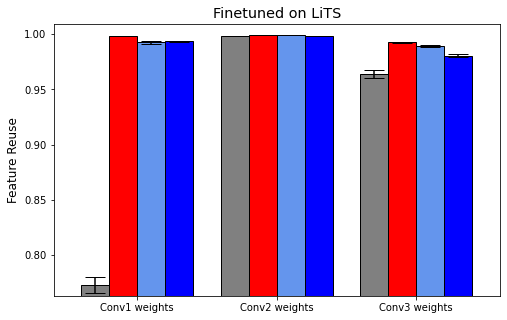

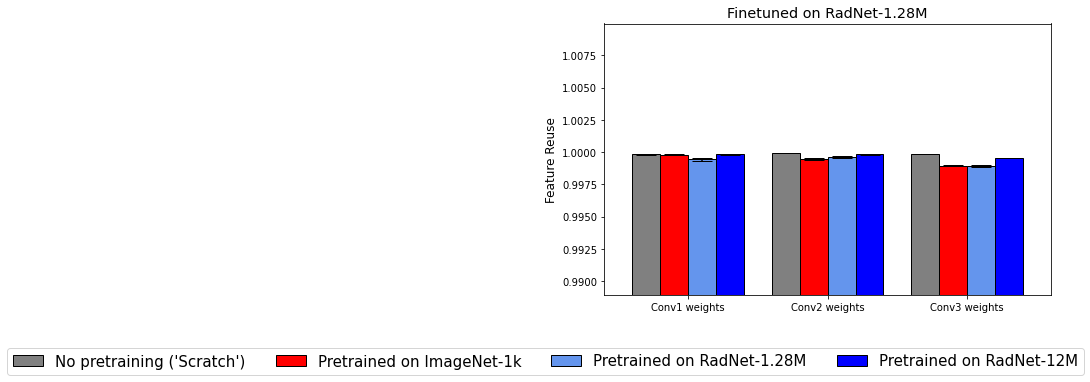

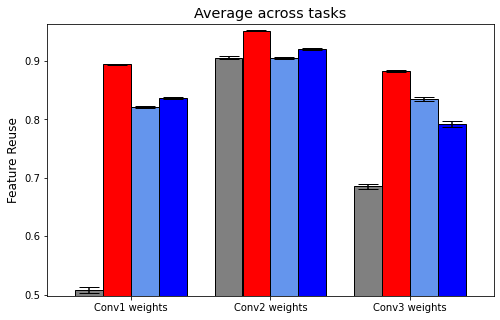

In [15]:
# Individual figures

for k, task in enumerate(["FT_BraTS", "FT_CX8", "FT_I1k", "FT_LiTS", "FT_R"]):
    fig = plt.figure(figsize = (8, 5))
    plt.rcParams.update({'axes.titlesize': 'x-large'})
    plt.rcParams.update({'axes.labelsize': 'large'})
    plt.title(f"{screen_names[task]}")
    plt.xticks([1.5, 4, 6.5], ["Conv1 weights", "Conv2 weights", "Conv3 weights"])
    plt.ylabel("Feature Reuse")
    plt.xlim(0, 8)
    plt.ylim(
        min([results_means[(pn, task, L)] - 0.01 for pn in pt_names for L in ["_L1", "_L2", "_L3"]]),
        max([results_means[(pn, task, L)] + results_stds[(pn, task, L)] + 0.01 for pn in pt_names for L in ["_L1", "_L2", "_L3"]])
        )
    for j, L in enumerate(["_L1", "_L2", "_L3"]):
        bars = [results_means[(pn, task, L)] for pn in pt_names]
        errs = [results_stds[(pn, task, L)] for pn in pt_names]
        labels = [screen_names[pn] for pn in pt_names]
        colors = [ttc_palette[pn] for pn in pt_names]
        pos = [0.5*i + 2.5*j + 0.5 for i in range(len(pt_names))]
        plt.bar(
            x = pos,
            height = bars,
            width = 0.5,
            yerr = errs,
            capsize = 10,
            label = labels,
            color = colors,
            align = "edge",
            edgecolor = "k",
            linewidth = 1
        )
    plt.savefig(f"./figures/Feature_Reuse_{task}.svg", format = "svg", bbox_inches = "tight")

plt.figure(figsize = (8, 5))
plt.rcParams.update({'axes.titlesize': 'x-large'})
plt.rcParams.update({'axes.labelsize': 'large'})
plt.title("Average across tasks")
plt.xticks([1.5, 4, 6.5], ["Conv1 weights", "Conv2 weights", "Conv3 weights"])
plt.ylabel("Feature Reuse")
plt.xlim(0, 8)
for pn in pt_names:
    for L in ["_L1", "_L2", "_L3"]:
        results_means[(pn, "avg", L)] = np.mean([results_means[(pn, task, L)] for task in ["FT_BraTS", "FT_CX8", "FT_I1k", "FT_LiTS", "FT_R"]])
        results_stds[(pn, "avg", L)] = 1/5 * np.sqrt(sum([results_stds[(pn, task, L)]**2 for task in ["FT_BraTS", "FT_CX8", "FT_I1k", "FT_LiTS", "FT_R"]]))
plt.ylim(
    min([results_means[(pn, "avg", L)] - 0.01 for pn in pt_names for L in ["_L1", "_L2", "_L3"]]),
    max([results_means[(pn, "avg", L)] + results_stds[(pn, "avg", L)] + 0.01 for pn in pt_names for L in ["_L1", "_L2", "_L3"]])
    )
for j, L in enumerate(["_L1", "_L2", "_L3"]):
    bars = [results_means[(pn, "avg", L)] for pn in pt_names]
    errs = [results_stds[(pn, "avg", L)] for pn in pt_names]
    colors = [ttc_palette[pn] for pn in pt_names]
    pos = [0.5*i + 2.5*j + 0.5 for i in range(len(pt_names))]
    for l in range(len(pos)):
        if j == 2:
            plt.bar(
                x = pos[l],
                height = bars[l],
                width = 0.5,
                yerr = errs[l],
                capsize = 10,
                label = labels[l],
                color = colors[l],
                align = "edge",
                edgecolor = "k",
                linewidth = 1
            )
        else:
            plt.bar(
                x = pos[l],
                height = bars[l],
                width = 0.5,
                yerr = errs[l],
                capsize = 10,
                color = colors[l],
                align = "edge",
                edgecolor = "k",
                linewidth = 1
            )
plt.savefig(f"./figures/Feature_Reuse_Average.svg", format = "svg", bbox_inches = "tight")

handles, labels = plt.gca().get_legend_handles_labels()
legend = fig.legend(handles, labels, bbox_to_anchor = [0.97, 0.0], prop = {'size': 15}, ncol = 4)
bbox  = legend.get_window_extent()
bbox = bbox.from_extents(*(bbox.extents + np.array([-5, -5, 5, 5])))
bbox = bbox.transformed(legend.figure.dpi_scale_trans.inverted())
legend.figure.savefig(f"./figures/Feature_Reuse_legend.svg", format = "svg", dpi = "figure", bbox_inches = bbox)

In [16]:
# Feature Uniqueness

def feature_uniqueness(acts, axis = 0, n_split = 8):

    # Even splits are necessary for unbiased results
    if acts.size()[axis] % n_split != 0:
        raise ValueError(f"PT activations with shape {acts.size()} must be evenly splittable along axis {axis} using n_split = {n_split}!")

    # Test n_split times each
    results = []
    r = acts.size()[axis] // n_split
    for s1 in range(n_split):
        for s2 in range(n_split):

            # Tests are symmetrical, no need to do double the work
            if s1 >= s2:
                continue
            
            # Get CKA similarity
            sim = CCKA_inst.kernel_CKA(
                torch.index_select(acts, dim = axis, index = torch.tensor([x for x in range(r*s1, r*(s1+1))]).to("cuda:0")),
                torch.index_select(acts, dim = axis, index = torch.tensor([x for x in range(r*s2, r*(s2+1))]).to("cuda:0"))
                ).detach().cpu().numpy()
            
            # Append uniqueness value
            results.append(1 - sim)

    return np.mean(results), np.std(results)

In [17]:
uniqueness_means = {}
uniqueness_stds = {}

pt_names = ["PT_Scratch", "PT_SimCLR_I1k", "PT_SimCLR_R", "PT_SimCLR_RF"]

for pn in tqdm(pt_names):
    for L in tqdm(["_L1", "_L2", "_L3"]):
        u_ms, u_ss = [], []
        #for variation in get_variations(pn+L) get the uniqueness of that variation, not applicable to pt_acts
        u_m, u_s = feature_uniqueness(layer_weights[pn+L], axis = 0, n_split = 8)
        u_ms.append(u_m)
        u_ss.append(u_s)
        uniqueness_means[(pn, L)] = np.mean(u_ms)
        uniqueness_stds[(pn, L)] = np.sqrt(sum([x**2 for x in u_ss]))

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

In [18]:
for k, v in uniqueness_means.items():
    print(f"{k}: {uniqueness_means[k]} +/- {uniqueness_stds[k]}")

('PT_Scratch', '_L1'): 0.9843103943858296 +/- 0.00360126214233165
('PT_Scratch', '_L2'): 0.06474845537117549 +/- 0.013276162301942932
('PT_Scratch', '_L3'): 0.3940751850605011 +/- 0.00981601797907342
('PT_SimCLR_I1k', '_L1'): 0.9289813436168645 +/- 0.03348190062342031
('PT_SimCLR_I1k', '_L2'): 0.17793981730937958 +/- 0.04074739500540785
('PT_SimCLR_I1k', '_L3'): 0.3869413435459137 +/- 0.0646653784134074
('PT_SimCLR_R', '_L1'): 0.9728279510745779 +/- 0.012844543405124203
('PT_SimCLR_R', '_L2'): 0.30946155743939535 +/- 0.07932434874774168
('PT_SimCLR_R', '_L3'): 0.5604304469057492 +/- 0.043936531539311846
('PT_SimCLR_RF', '_L1'): 0.9762562597004164 +/- 0.012513210035718743
('PT_SimCLR_RF', '_L2'): 0.21447291331631796 +/- 0.05156642765413315
('PT_SimCLR_RF', '_L3'): 0.49984843709639143 +/- 0.05956588299503824


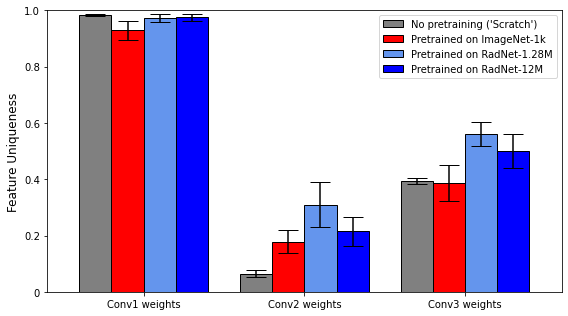

In [19]:
plt.figure(figsize = (8, 4.5))
plt.xticks(ticks = [1.5, 4, 6.5], labels = ["Conv1 weights", "Conv2 weights", "Conv3 weights"])
plt.yticks(ticks = [0, 0.2, 0.4, 0.6, 0.8, 1.0], labels = [0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.ylabel("Feature Uniqueness")
plt.xlim(0, 8)
plt.ylim(
    #min([uniqueness_means[(pn, L)] - 0.01 for pn in pt_names for L in ["_L1", "_L2", "_L3"]]),
    0,
    #max([uniqueness_means[(pn, L)] + uniqueness_stds[(pn, L)] + 0.01 for pn in pt_names for L in ["_L1", "_L2", "_L3"]]))
    1)
plt.rcParams.update({'axes.titlesize': 'x-large'})
plt.rcParams.update({'axes.labelsize': 'large'})
for j, L in enumerate(["_L1", "_L2", "_L3"]):
    bars = [uniqueness_means[(pn, L)] for pn in pt_names]
    errs = [uniqueness_stds[(pn, L)] for pn in pt_names]
    if j == 2:
        labels = [screen_names[pn] for pn in pt_names]
    else:
        labels = ["", "", "", ""]
    colors = [ttc_palette[pn] for pn in pt_names]
    pos = [0.5*i + 2.5*j + 0.5 for i in range(len(pt_names))]
    for l in range(len(pos)):
        plt.bar(
            x = pos[l],
            height = bars[l],
            width = 0.5,
            yerr = errs[l],
            capsize = 10,
            label = labels[l],
            color = colors[l],
            align = "edge",
            edgecolor = "k",
            linewidth = 1
            )
plt.legend(loc = 'upper right')
plt.tight_layout()
plt.savefig("./figures/uniqueness.svg", format = "svg", bbox_inches = "tight")

In [ ]:
# "Who knew what?" plots

def get_testing_equipment(cfg_name):

    class Arg:
        pass

    # Argument parsing like in finetune.py
    config = uu.yaml_config_hook(cfg_name)
    args = Arg()
    for k, v in config.items():
        setattr(args, k, v)

    # Defaults like in finetune.py
    args.save_path = os.path.join("../../logs_and_checkpoints/finetuning/", args.name)
    if not "debug" in vars(args):
        args.debug = False
    if not "test_nan_inf" in vars(args):
        args.test_nan_inf = True
    if not os.path.exists(args.save_path):
        os.makedirs(args.save_path)

    if isinstance(vars(args).get("w_l", None), list):
        args.w_l = torch.Tensor(args.w_l)
    else:
        args.w_l = None
    if isinstance(vars(args).get("w_m", None), list):
        args.w_m = torch.Tensor(args.w_m)
    else:
        args.w_m = None

    # Seeding like in finetune.py
    torch.manual_seed(args.seed)
    np.random.seed(args.seed)
    random.seed(args.seed)
    
    args.opmode = "disk"
    args.verbose = False
    
    dataset, model, _, _, _ = ftasks.finetuning_task(args, manager = None)
    _, ft_model_path = get_model_paths(cfg_name)
    sd = torch.load(ft_model_path, map_location = args.device)
    model.module.load_state_dict(sd, strict = True)
    model.to(args.device)

    return dataset, model, args

In [ ]:
pt_codes = {
    "PT_Scratch": 1,
    "PT_SimCLR_I1k": 2,
    "PT_SimCLR_R": 4,
    "PT_SimCLR_RF": 8
}
pt_codes_inv = {v: k for k, v in pt_codes.items()}

def test_everything(dataset, model, args, memory):

    dataset.set_state("test")
    dataset.set_used_subset("test")
    model.eval()

    loader = torch.utils.data.DataLoader(dataset, num_workers = 8, batch_size = 256, shuffle = True)

    for step, (data, idxs, targets) in tqdm(enumerate(loader), total=(len(dataset.subsets["test"])//256)+1):

        # To device
        data = data.to(device = device)
        idxs = idxs.to(device)
        targets = targets.to(device)
        
        # Do model calculation
        with torch.cuda.amp.autocast(enabled = True), torch.no_grad():
            preds, _ = model(data, targets)
            pc = torch.argmax(preds, dim=1).flatten()
        for i in idxs[pc == targets]:
            i = i.item()
            if i in memory:
                memory[i] += pt_codes[args.pt]
            else:
                memory[i] = pt_codes[args.pt]
        for i in idxs[pc != targets]:
            i = i.item()
            if not i in memory:
                memory[i] = 0

def test_everything_lits(dataset, model, args, memory):

    dataset.set_state("test")
    dataset.set_used_subset("test")
    model.eval()

    loader = torch.utils.data.DataLoader(dataset, num_workers = 8, batch_size = 256, shuffle = True)

    memory["indices"] = {}
    for step, (data, idxs, targets) in tqdm(enumerate(loader), total=(len(dataset.subsets["test"])//256)+1):

        # To device
        data = data.to(device = device)
        idxs = idxs.to(device)
        targets = [target_mask.to(device) for target_mask in targets]
        
        # Do model calculation
        with torch.cuda.amp.autocast(enabled = True), torch.no_grad():
            preds, _ = model(data, targets)
            pc = torch.argmax(preds, dim=1)

            all_targets = [torch.ones_like(targets[0]).to(targets[0].device)]
            all_targets.extend(targets)
            ct = torch.squeeze(2 - torch.argmax(torch.stack(tensors = all_targets[::-1], dim = 1), dim = 1))
            hits = ((pc == ct) * (ct != 0)).to(torch.int8) * pt_codes[args.pt]
            hits -= (ct == 0).to(torch.int8)

        memory["indices"][step] = idxs
        if step in memory:
            memory[step] += hits
            memory[step] = torch.clamp(memory[step], -1, None)
        else:
            memory[step] = hits

In [ ]:
ft_models = {
    "I1k":{
        "PT_Scratch": "../../pkgs/FTE/config/E1/PT_Scratch_FT_I1k.yaml",
        "PT_SimCLR_I1k": "../../pkgs/FTE/config/E1/PT_SimCLR_I1k_FT_I1k.yaml",
        "PT_SimCLR_R": "../../pkgs/FTE/config/E1/PT_SimCLR_R_FT_I1k.yaml",
        "PT_SimCLR_RF": "../../pkgs/FTE/config/E1/PT_SimCLR_RF_FT_I1k.yaml"
    },
    "R":{
        "PT_Scratch": "../../pkgs/FTE/config/E1/PT_Scratch_FT_R.yaml",
        "PT_SimCLR_I1k": "../../pkgs/FTE/config/E1/PT_SimCLR_I1k_FT_R.yaml",
        "PT_SimCLR_R": "../../pkgs/FTE/config/E1/PT_SimCLR_R_FT_R.yaml",
        "PT_SimCLR_RF": "../../pkgs/FTE/config/E1/PT_SimCLR_RF_FT_R.yaml"
    },
    "LiTS":{
        "PT_Scratch": "../../pkgs/FTE/config/E1/PT_Scratch_FT_LiTS.yaml",
        "PT_SimCLR_I1k": "../../pkgs/FTE/config/E1/PT_SimCLR_I1k_FT_LiTS.yaml",
        "PT_SimCLR_R": "../../pkgs/FTE/config/E1/PT_SimCLR_R_FT_LiTS.yaml",
        "PT_SimCLR_RF": "../../pkgs/FTE/config/E1/PT_SimCLR_RF_FT_LiTS.yaml"
    },
    "I1k_L":{
        "PT_SimCLR_I1k": "../../pkgs/FTE/config/E4/PT_SimCLR_I1k_FT_I1k_lineval.yaml",
        "PT_SimCLR_R": "../../pkgs/FTE/config/E4/PT_SimCLR_R_FT_I1k_lineval.yaml",
        "PT_SimCLR_RF": "../../pkgs/FTE/config/E4/PT_SimCLR_RF_FT_I1k_lineval.yaml"
    },
    "R_L":{
        "PT_SimCLR_I1k": "../../pkgs/FTE/config/E4/PT_SimCLR_I1k_FT_R_lineval.yaml",
        "PT_SimCLR_R": "../../pkgs/FTE/config/E4/PT_SimCLR_R_FT_R_lineval.yaml",
        "PT_SimCLR_RF": "../../pkgs/FTE/config/E4/PT_SimCLR_RF_FT_R_lineval.yaml"
    },
    "LiTS_L":{
        "PT_SimCLR_I1k": "../../pkgs/FTE/config/E4/PT_SimCLR_I1k_FT_LiTS_lineval.yaml",
        "PT_SimCLR_R": "../../pkgs/FTE/config/E4/PT_SimCLR_R_FT_LiTS_lineval.yaml",
        "PT_SimCLR_RF": "../../pkgs/FTE/config/E4/PT_SimCLR_RF_FT_LiTS_lineval.yaml"
    }
}
memory = {"I1k":{}, "R":{}, "LiTS":{}, "I1k_L":{}, "R_L":{}, "LiTS_L":{}}

for group in ft_models:
    for pn, cfg in ft_models[group].items():
        dataset, model, args = get_testing_equipment(cfg)

        args.pt = pn
        torch.manual_seed(args.seed)
        np.random.seed(args.seed)
        random.seed(args.seed)
        if "LiTS" in group:
            test_everything_lits(dataset, model, args, memory[group])
        else:
            test_everything(dataset, model, args, memory[group])

In [ ]:
def rec_rolls(num, chances):
    cval = 1
    if num > 0:
        for c in [8, 4, 2, 1]:
            if num >= c:
                cval *= chances.get(pt_codes_inv[c], 0)
                num -= c
            else:
                cval *= (1 - chances.get(pt_codes_inv[c], 0))
    if cval == 1:
        return math.prod([1 - chance for chance in list(chances.values())])
    else:
        return cval

In [ ]:
who_knows_what_c = {x: plt.cm.tab20(x) for x in range(16)}
who_knows_what_names = {
    0: "No predictors",
    1: "Scratch (S)",
    2: "ImageNet-1k (I)",
    3: "S, I",
    4: "RadNet-1.28M (R)",
    5: "S, R",
    6: "I, R",
    7: "S, I, R",
    8: "RadNet-12M (R12M)",
    9: "S, R12M",
    10: "I, R12M",
    11: "S, I, R12M",
    12: "R, R12M",
    13: "S, R, R12M",
    14: "I, R, R12M",
    15: "S, I, R, R12M"
}
group_screen_names = {
    "I1k": "Finetuning on ImageNet-1k",
    "R": "Finetuning on RadNet-1.28M",
    "LiTS": "Finetuning on LiTS",
    "I1k_L": "Linear evaluation on ImageNet-1k",
    "R_L": "Linear evaluation on RadNet-1.28M",
    "LiTS_L": "Linear evaluation on LiTS"
}

for group in ft_models:

    chances = {}
    expected = {}

    for pn, cfg in ft_models[group].items():
        log_loc = "/".join(cfg.split("/")[-2:])[:-5]+"/test.log"
        log_base = "../../logs_and_checkpoints/finetuning/"
        with open(log_base+log_loc, "r") as o:
            lines = o.readlines()
        acc = lines[1].split(",")[0]
        chances[pn] = float(acc)

    for x in range(16):
        expected[x] = rec_rolls(x, chances)

    print(f"Task: {group}")
    if "LiTS" in group:
        vals = torch.concat([t.flatten() for t in memory[group].values() if not isinstance(t, dict)]).cpu().numpy()
    else:
        vals = list(memory[group].values())
    c = Counter(vals)
    sum_test = sum(list([v for k, v in c.items() if k != -1])) # should be 25k for I/R and 3038*256*256 * a few percent for LiTS
    for k in range(16):
        if not k in c:
            c[k] = 0
    for k, v in sorted(c.items()):
        if k == -1:
            continue
        print(f"{k}: {v} +/- {np.sqrt(v)} ({v/sum_test * 100:.3f}%), expected {expected[k]*sum_test}")

    fig = plt.figure(figsize = (8, 5))
    # Results
    plt.bar(
        x = [p*1.25 for p in range(16)],
        height = [v/sum_test for k, v in sorted(c.items()) if k != -1],
        width = 0.5,
        align = "center",
        yerr = [np.sqrt(v)/sum_test for k, v in sorted(c.items()) if k != -1], # assume a poisson error for counts
        capsize = 5,
        color = [who_knows_what_c[k] for k, v in sorted(c.items()) if k != -1],
        edgecolor = "k",
        linewidth = 1
    )
    # Fully random expectation
    plt.bar(
        x = [p*1.25+0.5 for p in range(16)],
        height = [expected[k] for k, v in sorted(c.items()) if k != -1],
        width = 0.5,
        align = "center",
        color = [who_knows_what_c[k] for k, v in sorted(c.items()) if k != -1],
        edgecolor = "k",
        linewidth = 1,
        hatch = "XX"
    )
    # Custom
    plt.bar(
        x = [22, 23.25, 24.5, 25.75],
        height = [
            sum([c[x] for x in [2, 3, 10, 11]]) / sum_test, # I + !R
            sum([c[x] for x in [4, 5, 12, 13]]) / sum_test, # R + !I
            sum([c[x] for x in [2, 3, 6, 7]])   / sum_test, # I + !R12M
            sum([c[x] for x in [8, 9, 12, 13]]) / sum_test  # R12M + !I
        ],
        yerr = [
            np.sqrt(sum([c[y] for y in x]))/sum_test
            for x in [
                [2, 3, 10, 11],
                [4, 5, 12, 13], 
                [2, 3, 6, 7], 
                [8, 9, 12, 13]
                ]
            ],
        capsize = 5,
        width = 0.5,
        align = "center",
        color = ["lightcoral", "cornflowerblue", "red", "blue"],
        edgecolor = "k",
        linewidth = 1
    )
    print([
            sum([c[x] for x in [2, 3, 10, 11]]) / sum_test, # I + !R
            sum([c[x] for x in [4, 5, 12, 13]]) / sum_test, # R + !I
            sum([c[x] for x in [2, 3, 6, 7]])   / sum_test, # I + !R12M
            sum([c[x] for x in [8, 9, 12, 13]]) / sum_test  # R12M + !I
        ])
    print([
            np.sqrt(sum([c[y] for y in x]))/sum_test
            for x in [
                [2, 3, 10, 11],
                [4, 5, 12, 13], 
                [2, 3, 6, 7], 
                [8, 9, 12, 13]
                ]
            ]) # DEBUG
    # Custom, random expectation
    plt.bar(
        x = [22.5, 23.75, 25, 26.25],
        height = [
            sum([expected[x] for x in [2, 3, 10, 11]]), # I + !R
            sum([expected[x] for x in [4, 5, 12, 13]]), # R + !I
            sum([expected[x] for x in [2, 3, 6, 7]])  , # I + !R12M
            sum([expected[x] for x in [8, 9, 12, 13]])  # R12M + !I
        ],
        capsize = 5,
        width = 0.5,
        align = "center",
        color = ["lightcoral", "cornflowerblue", "red", "blue"],
        edgecolor = "k",
        linewidth = 1,
        hatch = "XX"
    )
    ticks = [p*1.25 for p in range(16)]
    ticks.extend([22, 23.25, 24.5, 25.75])
    ticklabels = [who_knows_what_names[k] for k, v in sorted(c.items()) if k != -1]
    ticklabels.extend(["I, ¬R", "R, ¬I", "I, ¬R12M", "R12M, ¬I"])
    plt.xticks(ticks = ticks, labels = ticklabels)
    fig.autofmt_xdate(rotation = 45)
    plt.ylabel("Fraction of correct predictions")
    plt.yscale("log")
    plt.gca().yaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ylow = {
        "I1k": 8e-3,
        "R": 1e-4,
        "LiTS": 1e-5,
        "I1k_L": 1e-2,
        "R_L": 1e-4,
        "LiTS_L": 1e-5
    }
    plt.vlines(20.625, ylow[group], 1, "k", "--")
    plt.ylim(ylow[group], 1)
    plt.title(f"Task: {group_screen_names[group]}")
    plt.savefig(f"./figures/wkw_{group}_summary.svg", format = "svg", bbox_inches = "tight")

In [ ]:
max_diff = 0
max_step = 0
max_x = 0
diff_images = []
for step, images in memory["LiTS_L"].items():
    if not isinstance(images, dict):
        for x in range(images.size()[0]):
            sum_I = sum(torch.sum(images[x, :, :] == n) for n in [2, 3, 6, 7])
            sum_R12 = sum(torch.sum(images[x, :, :] == n) for n in [8, 9, 12, 13])
            diff = sum_R12 - sum_I
            if diff > 200 and diff < 1000:
                diff_images.append((step, x, diff))

In [ ]:
for t in diff_images:
    print(t)

In [ ]:
# Where does ImageNet fail while RadNet-X does not?

#sample_step, sample_x = 0, 247 # <- border
#sample_step, sample_x = 1, 200 # <- border, low contrast in border region
#sample_step, sample_x = 7, 175 # <- insular
sample_step, sample_x = 9, 173 # <- semi-insular, low contrast

test_set_id = memory["LiTS_L"]["indices"][sample_step][sample_x]
example_image_id = dataset.subsets["test"][test_set_id]
example_image, _, example_target = dataset._load(example_image_id)
example_image = example_image.to(torch.float32).cpu().numpy()
example_image -= np.min(example_image)
example_image /= np.max(example_image)
example_target_liver = example_target[0].to(torch.uint8).cpu().numpy()[0, ::-1, :]
example_target_liver = np.stack(
    [
        np.zeros_like(example_target_liver),
        example_target_liver * 255,
        np.zeros_like(example_target_liver),
        example_target_liver * 100
    ],
    axis = -1
)
example_target_lesion = example_target[1].to(torch.uint8).cpu().numpy()[0, ::-1, :]
example_target_lesion = np.stack(
    [
        example_target_lesion * 255,
        np.zeros_like(example_target_lesion),
        np.zeros_like(example_target_lesion),
        example_target_lesion * 100
    ],
    axis = -1
)

# empty
plt.figure()
plt.imshow(example_image[::-1, ::-1])
plt.axis("off")
plt.savefig(f"./figures/wkw_{group}_{sample_step}_{sample_x}_base.png", dpi = 600)

# ground truth
plt.figure()
plt.imshow(example_image[::-1, ::-1])
plt.imshow(example_target_liver[:, ::-1])
plt.imshow(example_target_lesion[:, ::-1])
plt.axis("off")
plt.savefig(f"./figures/wkw_{group}_{sample_step}_{sample_x}_gt.png", dpi = 600)

# R12 and not I predictions
example_prediction_1 = memory["LiTS_L"][sample_step][sample_x, :, :] # 11/206 as an example image
example_prediction_diff_1 = torch.sum(
    torch.stack(
        [(example_prediction_1 == x) for x in [8, 9, 12, 13]], 
        dim = -1
        ), 
    dim = -1
        ).to(torch.uint8).cpu().numpy()
example_prediction_diff_1 = np.stack(
    [
        np.zeros_like(example_prediction_diff_1),
        np.zeros_like(example_prediction_diff_1),
        example_prediction_diff_1 * 255,
        example_prediction_diff_1 * 100
    ],
    axis = -1
)
# I and not R12 predictions
example_prediction_2 = memory["LiTS_L"][sample_step][sample_x, :, :] # 11/206 as an example image
example_prediction_diff_2 = torch.sum(
    torch.stack(
        [(example_prediction_2 == x) for x in [2, 3, 6, 7]], 
        dim = -1
        ), 
    dim = -1
        ).to(torch.uint8).cpu().numpy()
example_prediction_diff_2 = np.stack(
    [
        example_prediction_diff_2 * 255,
        example_prediction_diff_2 * 255,
        np.zeros_like(example_prediction_diff_2),
        example_prediction_diff_2 * 100
    ],
    axis = -1
)
plt.figure()
plt.imshow(example_image[::-1, ::-1])
plt.imshow(example_prediction_diff_1[::-1, ::-1, :])
plt.imshow(example_prediction_diff_2[::-1, ::-1, :])
plt.axis("off")
plt.savefig(f"./figures/wkw_{group}_{sample_step}_{sample_x}_diff.png", dpi = 600)
